In [1]:
import re
import os
import random as rd
import tensorflow as tf
import matplotlib.pyplot as plt
import pyBigWig as pbg
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.stats
from scipy import sparse

2023-02-15 15:50:25.800953: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 15:50:25.936576: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-15 15:50:25.956302: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-15 15:50:25.956313: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [2]:
def ohe(seq):
    seq2=list()
    mapping = {"A":[1, 0, 0, 0], "C": [0, 1, 0, 0], "G": [1, 0, 0, 0], "T":[0, 0, 0, 1]}
    for i in seq:
      seq2.append(mapping[i]  if i in mapping.keys() else [0, 0, 0, 0]) 
    return np.array(seq2)

In [4]:
#fasta to ohe numpy
f=open('/home/florian/projet/r6.16/dmel-all-chromosome-r6.16.fasta','r')
os.chdir('/home/florian/projet/r6.16')
chr_name = str()
seq=[]
D={}
for line in f:
        line = line.rstrip()
        if line[0] == '>':
                if line[1:3]=="2C":
                        break
                if seq != []:
                        D[chr_name]=ohe(seq)
                chr_name = line[1:3].strip()
                seq = []
        else:
                seq += line
D["Y"]=ohe(seq)
np.savez_compressed('seq',**D)

In [35]:
#bigwig to numpy
os.chdir('/home/florian/projet/scATACseq')
fichiers=os.listdir('/home/florian/projet/scATACseq')
valeurs = []
array=np.array(())
for file in fichiers:
    #print("processing file", file)
    bw=pbg.open(file)
    array = np.concatenate((bw.values("2L",0,-1,numpy=True),bw.values("2R",0,-1,numpy=True),bw.values("3R",0,-1,numpy=True),bw.values("3L",0,-1,numpy=True),bw.values("4",0,-1,numpy=True),bw.values("X",0,-1,numpy=True),bw.values("Y",0,-1,numpy=True)))
    if len(valeurs) == 0:
        valeurs = array
    else:
        valeurs += array
os.chdir('/home/florian/projet')
np.savez_compressed('scATACseq',valeurs=valeurs)

In [51]:
#bigwig to numpy v2
os.chdir('/home/florian/projet/scATACseq')
fichiers=os.listdir('/home/florian/projet/scATACseq')
valeurs =[]
chr=["2L","2R","3R","3L","4","X","Y"]
Dic={"2L"}
for file in fichiers:
    #print("processing file", file)
    bw=pbg.open(file)
    array = np.array(())
    for j in chr:
        array=np.append(array,bw.values(j,0,-1,numpy=True))
    if len(valeurs) == 0:
        valeurs = array
    else:
        valeurs += array
os.chdir('/home/florian/projet')
np.savez_compressed('scATACseq',valeurs=valeurs)

In [ ]:
#bigwig to sparse
os.chdir('/home/florian/projet/scATACseq')
fichiers=os.listdir('/home/florian/projet/scATACseq')
values=[]
for file in fichiers:
    bw=pbg.open(file)
    array=np.concatenate((bw.values("4",0,-1,numpy=True),bw.values("X",0,-1,numpy=True),bw.values("Y",0,-1,numpy=True),bw.values("2L",0,-1,numpy=True),bw.values("2R",0,-1,numpy=True),bw.values("3L",0,-1,numpy=True),bw.values("3R",0,-1,numpy=True)))
    values.append(sparse.csr_matrix(array))

In [2]:
#normalization
val=np.load('/home/florian/projet/scATACseq.npz')['valeurs']
val[val >= 2000] = 2000
val=val/2000

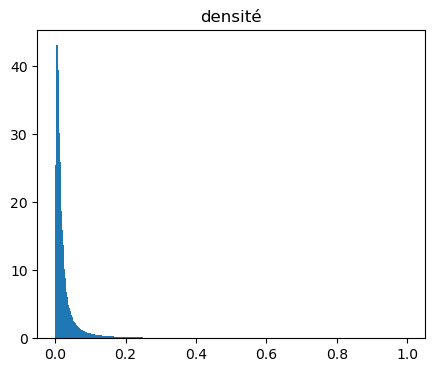

In [73]:
plt.figure(figsize=(5,4))
plt.hist(val,bins=500, density=True)
plt.title("densité")
#plt.xscale('log')
#plt.yscale('log')
plt.show()

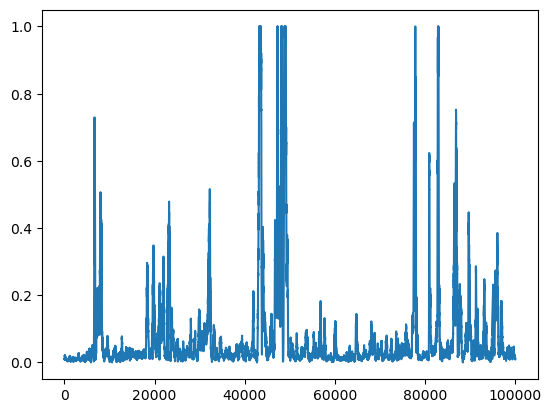

In [21]:
plt.plot((val[1000000:1100000]))

In [29]:
len((np.load('/home/florian/projet/r6.16/seq.npz')['2L']))
LEN=np.arange(1000,23512712)#fenêtre de la taille du chromosome 2L -1000 à gauche et -1001 à droite
dataset=rd.choices(LEN,k=10000)

In [10]:
#create dataset section
start = 100_000
stop = start + 100_000
Ytrain_chr2L=val[start:stop]
chr2L=np.load('/home/florian/projet/r6.16/seq.npz')['2L']
Xtrain_chr2L=[]
for i in range(start,stop):
    Xtrain_chr2L.append(chr2L[i-1000:i+1001])
print('2')
Xtrain_chr2L = np.array(Xtrain_chr2L)


2


In [3]:
class MySequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size, max_data=2**20, WINDOW=2001):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.WINDOW = WINDOW
        n_data = min(len(self.x)-self.WINDOW+1, max_data)
        self.indices = np.arange(self.WINDOW//2, n_data+self.WINDOW//2)
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        #batch_x_indices = np.arange([idx * self.batch_size:(idx + 1) *self.batch_size])
        # batch_x = Xtrain_chr2L=[]
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        # for i in batch_indices:
        #     if i+2001 > len(self.x):
        #         break
        #     batch_x.append(self.x[i:i+2001])
        window_indices = batch_indices.reshape(-1, 1) + np.arange(-(self.WINDOW//2), self.WINDOW//2 + 1).reshape(1, -1)
        batch_x = self.x[window_indices]

        # batch_x = np.array(Xtrain_chr2L)
        batch_y = self.y[batch_indices]
        #batch_x = self.extract_windows(indices)
        return batch_x, batch_y
        return np.array([
            resize(imread(file_name), (200, 200))
               for file_name in batch_x]), np.array(batch_y)
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)
    #def extract_windows(self, indices):
        # function to get windows
        # return windows

    


In [4]:
x=np.load('/home/florian/projet/r6.16/seq.npz')['2L']
y=np.copy(val)[:len(x)]
x_valid=np.load('/home/florian/projet/r6.16/seq.npz')['2R']
y_valid=np.copy(val)[len(x):len(x)+len(x_valid)]
gen = MySequence(x, y, 1024, max_data=2**16)
gen_valid = MySequence(x_valid, y_valid, 1024, max_data=2**14)

In [124]:
a = gen.__getitem__(0)

In [125]:
a[0].shape

(1024, 2001, 4)

In [30]:
#create dataset random
Yrtrain_chr2L=np.copy(val[dataset])
chr2L=np.copy(np.load('/home/florian/projet/r6.16/seq.npz')['2L'])
Xrtrain_chr2L=[]
for i in dataset:
    Xrtrain_chr2L.append(np.array(chr2L[i-1000:i+1001]))
Xrtrain_chr2L = np.array(Xrtrain_chr2L)


In [16]:
import keras.backend as K
def mae_cor(y_true, y_pred):
    """Compute loss with Mean absolute error and correlation.
        :Example:
        >>> model.compile(optimizer = 'adam', losses = mae_cor)
        >>> load_model('file', custom_objects = {'mae_cor : mae_cor})
    """
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)

    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))

    cor = sigma_XY/(sigma_X*sigma_Y + K.epsilon())
    mae = K.mean(K.abs(y_true - y_pred))

    return (1 - cor) + mae

def mse_cor(y_true, y_pred):
    """Compute loss with Mean squared error and correlation.
    """
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)

    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))

    cor = sigma_XY/(sigma_X*sigma_Y + K.epsilon())
    mse = K.sqrt(K.mean(K.abs(y_true - y_pred)**2))

    return (1 - cor) + mse

In [17]:
#modèle

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(128, kernel_size=(6), activation='relu', input_shape=(2001,4)),
    tf.keras.layers.MaxPooling1D(pool_size=(4)),
    tf.keras.layers.Conv1D(64, kernel_size=(12), activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=(4)),
    tf.keras.layers.Conv1D(32, kernel_size=(12), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1) #activation="sigmoid")
    ])

loss_fn = tf.keras.losses.MeanSquaredError()

model.compile(loss=mse_cor,
    optimizer='adam',
    metrics=['mae'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1996, 128)         3200      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 499, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 488, 64)           98368     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 122, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 111, 32)           24608     
                                                                 
 flatten (Flatten)           (None, 3552)              0

In [92]:
history = model.fit(Xtrain_chr2L, Ytrain_chr2L, epochs=2, validation_split=0.1, verbose=1,batch_size=256)

NameError: name 'Xtrain_chr2L' is not defined

In [18]:
model.fit(gen, validation_data=gen_valid,epochs=2,verbose=1)

Epoch 1/2
64/64 [==============================] - 55s 847ms/step - loss: 0.3632 - mae: 0.0566 - val_loss: 1.2178 - val_mae: 0.0749
Epoch 2/2
64/64 [==============================] - 54s 848ms/step - loss: 0.0616 - mae: 0.0130 - val_loss: 1.2509 - val_mae: 0.0441


In [70]:
len(Xtrain_chr2L)==len(Ytrain_chr2L)

True

In [45]:
len((np.load('/home/florian/projet/r6.16/seq.npz')['2L']))+len(np.load('/home/florian/projet/r6.16/seq.npz')['2R'])+len(np.load('/home/florian/projet/r6.16/seq.npz')['3R'])+len(np.load('/home/florian/projet/r6.16/seq.npz')['3L'])+len(np.load('/home/florian/projet/r6.16/seq.npz')['4'])+len(np.load('/home/florian/projet/r6.16/seq.npz')['X'])+len(np.load('/home/florian/projet/r6.16/seq.npz')['Y'])

137547960

98/98 [==============================] - 23s 234ms/step


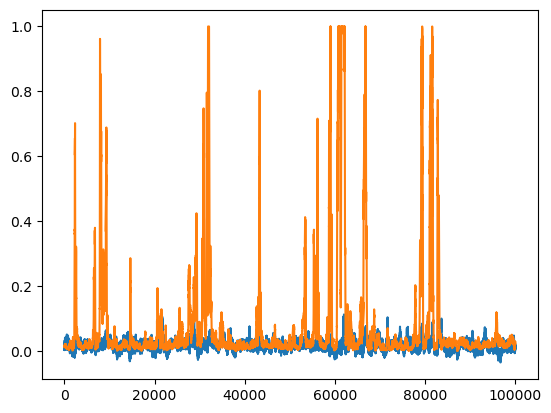

In [19]:
#prediction plot
pred=model.predict(Xtrain_chr2L, batch_size=1024)
plt.plot(pred)
plt.plot(Ytrain_chr2L)

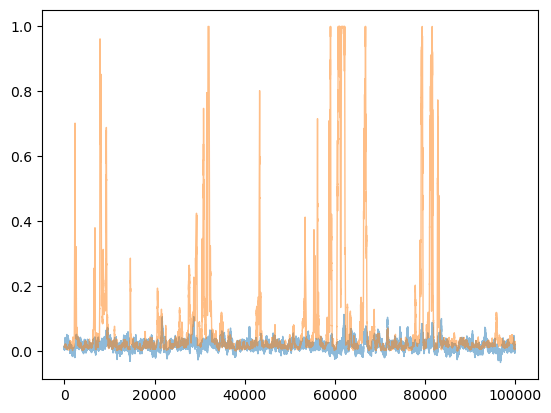

In [21]:
plt.plot(pred, alpha=0.5, linewidth=1)
plt.plot(Ytrain_chr2L, alpha=0.5, linewidth=1)
#plt.ylim((0, 0.1))
#plt.xlim((10_000, 20_000))

In [43]:
np.shape(Xtrain_chr2L[0])

(2001, 4)

In [23]:
len(val)

137547960

In [37]:
for i in range(10):
    print(len(val[(0.1*i < val) & (val < 0.1*(i+1))]))

127122856
4929055
1639222
881121
582047
424872
325513
251944
194719
139950


In [39]:
np.where((0.1 < val) & (val < 0.2))[0]

array([      377,       378,       379, ..., 137547944, 137547945,
       137547946])

In [42]:
model.predict(np.concatenate((np.zeros((1, 2001, 3)), np.ones((1, 2001, 1))), axis=-1))

1/1 [==============================] - 0s 14ms/step


array([[0.00976976]], dtype=float32)

In [41]:
np.concatenate((np.zeros((1, 2001, 3)), np.ones((1, 2001, 1))), axis=-1).shape

(1, 2001, 4)